In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import jax
import jax.numpy as jnp

# 1.) Game of Life

In [8]:
def num_neighbors(world, i, j, periodic=False):
    padded_world = world.tolist()
    if not periodic:  # to deal with edge cases, zero-pad 
        padded_world = [[0] + r  + [0] for r in padded_world]
        padded_world.insert(0, [0 for _ in range(len(padded_world[0]))])
        padded_world.append([0 for _ in range(len(padded_world[0]))])
    padded_world = np.array(world, dtype=bool)
    return np.sum(world[i-1:i+2, j-1:j+2]) - 1  # get the surrounding squares and sum them all up (since they are bool, this will count neighbors). Subtract 1 because this counts the cell itself

def gol_evlove(world, periodic=False):
    new_world = np.copy(world)
    for i in range(len(world)):
        for j in range(len(world[i])):
            neighbors = num_neighbors(world, i, j, periodic=periodic)
            if world[i, j] and (neighbors < 2 or neighbors > 3):  # Rules 1 and 3
                new_world[i, j] = False
            elif not world[i,j] and neighbors == 3:  # Rule 4
                new_world[i, j] = True
    return new_world

In [9]:
K = 30  # 30% living initially 
N = 16  # board size
world = np.array(random.choices([False, True], weights=(100 - K, K), k=N*N)).reshape((N, N))
gol_evlove(world);

In [13]:
worlds = [world]
for _ in range(30):
    worlds.append(gol_evlove(worlds[-1], periodic=False))

def world_to_img(world):
    fig, ax = plt.subplots()
    ax.imshow(world, interpolation='nearest')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return fig

In [12]:
# just for animation, not needed for solving the problem
from PIL import Image

images = [Image.fromarray(np.invert(w)).resize((300,300), resample=0).convert('P') for w in worlds]
images[0].save('./GameOfLife.gif', save_all=True, append_images=images[1:], optimize=False, duration=300, loop=1)

![GameOfLife](GameOfLife.gif "segment")

# 2. Recursive programming

In [17]:
def factorial(n):
    assert type(n) == int  # factorials only defined for integers
    return n * factorial(n-1) if n > 1 else 1

In [23]:
factorial(5)

120

# 3. Einstein Summation

In [11]:
r, theta, phi = 1., np.pi/4, np.sqrt(2)
coords = jnp.array([r, theta, phi])
g = jnp.array([[1., 0., 0.], [0., r**2, 0.], [0., 0., r**2 * jnp.sin(phi)**2]])

def get_g(coords):
    r, theta, phi = coords
    return jnp.array([[1., 0., 0.], [0., r**2, 0.], [0., 0., r**2 * jnp.sin(phi)**2]])

def christoffel(coords):
    g_inv = jnp.linalg.inv(get_g(coords))
    dg = jax.jacfwd(get_g)(coords)  # format: partial_i g_jk -> dg_jki
    return 1./2. * (jnp.einsum('kn,inj->kij', g_inv, dg) + jnp.einsum('kn,jni->kij', g_inv, dg) - jnp.einsum('kn,ijn->kij', g_inv, dg))  # format: \Gamma^i_jk
    
def riemann_tensor(coords):
    gamma = christoffel(coords)
    d_christoffel = jax.jacfwd(christoffel)(coords)  # format: partial_i Gamma^j_kl -> d_christoffel^j_kli
    return jnp.einsum('rnsm->rsmn', d_christoffel) - jnp.einsum('rmsn->rsnm', d_christoffel) + jnp.einsum('rml,lns->rsmn', gamma, gamma) - jnp.einsum('rnl,lms->rsmn', gamma, gamma) # format: R^\rho_\sigma\mu\nu

    
def ricci_tensor(coords):
    riem = riemann_tensor(coords)
    return jnp.einsum('rmrn',riem)

def ricci_scalar(coords):
    g_inv = jnp.linalg.inv(get_g(coords))
    ric = ricci_tensor(coords)
    return jnp.einsum('mn,mn', g_inv, ric)

In [13]:
ricci_scalar(jnp.array([r, theta, phi]))

Array(-2., dtype=float32)

# 4.) Regression

Current best fit: = [ 0.17269018 -0.46084192  1.2229712  -0.07101909]
Loss: 19150.171875
Current best fit: = [ 0.98976284 -0.82536066  0.26082426 -0.07658728]
Loss: 30.343153
Current best fit: = [ 1.2073238  -0.83727586  0.0557898  -0.01095174]
Loss: 8.637547
Current best fit: = [ 1.2488621  -0.8055467  -0.0185887   0.00984505]
Loss: 6.728848
Current best fit: = [ 1.2487037  -0.7650485  -0.06039108  0.01963892]
Loss: 6.022305
Current best fit: = [ 1.2390418  -0.7240648  -0.09320155  0.02655743]
Loss: 5.442147
Current best fit: = [ 1.2275789  -0.6845013  -0.12273725  0.032562  ]
Loss: 4.920986
Current best fit: = [ 1.2161276  -0.64674234 -0.15042175  0.03813419]
Loss: 4.449996
Current best fit: = [ 1.2051101  -0.61080337 -0.17664842  0.04339858]
Loss: 4.024170
Current best fit: = [ 1.1946019  -0.57662237 -0.20156345  0.04839643]
Loss: 3.639165


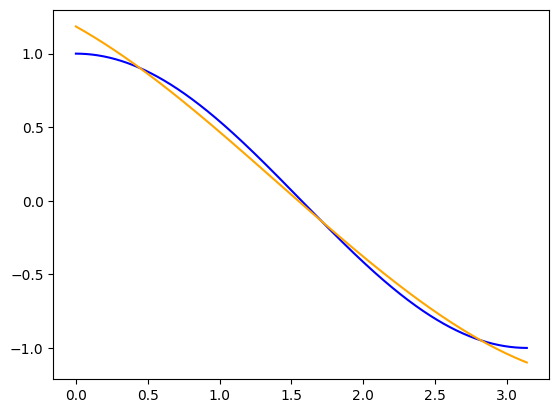

In [51]:
xs = jnp.arange(0, jnp.pi, jnp.pi/1000)
ys_exact = jnp.cos(xs)

# See week 3
def f(params):
    x_pows = jnp.array([xs**i for i in range(d + 1)])
    return jnp.einsum('i,ix->x', params, x_pows)

def loss(params):
    ys_hat = f(params)
    return jnp.sum((ys_exact - ys_hat)**2)

def gd(params, alpha=1e-3, max_iter=10000):
    for i in range(max_iter):
        if i % 1000 == 0:
            print("Current best fit: = {}".format(params))
            print("Loss: {:.6f}".format(loss(params)))
        params -= alpha * jax.grad(loss)(params)
    return params

# some random guess
d = 3
alpha = 5e-6
key = jax.random.PRNGKey(seed=1)
params = jax.random.normal(key, shape=(d + 1,))

params = gd(params, alpha=alpha)

plt.plot(xs, ys_exact, c='blue');
plt.plot(xs, f(params), c='orange');

# 5.) Fashion MNIST

This is literally the same as HW3, Problem 3.

In [151]:
from jax import grad, jit, vmap, random

# load data using tensorflow_datasets
import tensorflow_datasets as tfds
dataset_train = tfds.load('fashion_mnist', split='train', shuffle_files=False, with_info=False);
dataset_test = tfds.load('fashion_mnist', split='test', shuffle_files=False, with_info=False);

def preprocess(sample):
    image = sample['image']
    label = sample['label']
    # Normalize the image data
    image = jnp.array(image, dtype=jnp.float32) / 255.
    return image, label

data_generator = load_dataset()

def get_dataset(dataset):
    images, labels = [], []
    for s in tfds.as_numpy(dataset):
        im, l =preprocess(s)
        images.append(im)
        labels.append(l)
    return jnp.array(images), jnp.array(labels, dtype=int)

label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser', 
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

x_train, y_train = get_dataset(dataset_train)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2],))
x_test, y_test = get_dataset(dataset_test)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2],))
item_name = 'Dress'

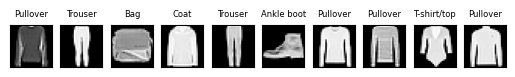

In [152]:
fig, axs = plt.subplots(1, 10)
for ax, imag, lab in zip(axs, x_train, y_train):
    ax.imshow(imag.reshape((28, 28)), cmap='gray', vmin=0, vmax=1);
    ax.set_title(label_dict[int(lab)], fontsize='6')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [153]:
def get_balanced_data_and_labels(item_name):
    find_item = [i for i in label_dict if label_dict[i] == item_name][0]
    shuffle_key = random.PRNGKey(0)
    number_positions = jnp.where(y_train == find_item)[0]
    other_positions = jnp.where(y_train != find_item)[0]
    # make the same length
    other_positions = other_positions[:len(number_positions)]
    # combine the index sets and shuffle them
    all_indices = jax.random.permutation(shuffle_key, jnp.hstack((number_positions, other_positions)))
    return x_train[all_indices], y_train[all_indices]

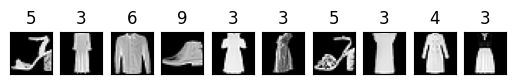

In [154]:
x_train, y_train = get_balanced_data_and_labels(item_name=item_name)
fig, axs = plt.subplots(1, 10)
for ax, digit, label in zip(axs, x, y):
    ax.imshow(digit.reshape((28, 28)), cmap='gray', vmin=0, vmax=1);
    ax.set_title(label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [155]:
# we will use sigmoid here. So we map things with a label "item_name" to +1 and others to 0
find_item = [i for i in label_dict if label_dict[i] == item_name][0]
y_train = jnp.array(y_train == find_item, dtype=jnp.float32)
y_test = jnp.array(y_test == find_item, dtype=jnp.float32)

In [156]:
key = jax.random.PRNGKey(0)
# Neural network architecture
def init_network_params(key):
    sizes = [28 * 28, 100, 100, 1]  # Number of nodes in each layer
    keys = random.split(key, len(sizes) - 1)
    params = [(1/jnp.sqrt(n) * random.normal(k, (m, n)), 1/n * random.normal(k, (n,))) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]
    return params

@jit
def neural_network(params, x):
    for i, (w, b) in enumerate(params):
        x = jnp.dot(x, w) + b
        if i != len(params) - 1:
            x = jax.nn.relu(x)
    return jax.nn.sigmoid(x)

# Mean squared error loss
@jit
def loss(params, x, y_true):
    y_pred = neural_network(params, x)
    return jnp.mean((y_pred.flatten() - y_true) ** 2)

# Initialize network parameters
params = init_network_params(key)
print("Summary of NN:")
total_num = 0
for i in range(len(params)):
    total_num += params[i][0].shape[0] * params[i][0].shape[1] + params[i][1].shape[0]
    print("Layer {}: Weights: {}, Biases: {}, Total: {} parameters".format(i + 1, 
                                                                     params[i][0].shape, 
                                                                     params[i][1].shape, 
                                                                     params[i][0].shape[0] * params[i][0].shape[1] + params[i][1].shape[0])
         )
print("The NN has {} parameters.\n\n".format(total_num))

Summary of NN:
Layer 1: Weights: (784, 100), Biases: (100,), Total: 78500 parameters
Layer 2: Weights: (100, 100), Biases: (100,), Total: 10100 parameters
Layer 3: Weights: (100, 1), Biases: (1,), Total: 101 parameters
The NN has 88701 parameters.




In [157]:
# Training loop
def train(params, X, y, learning_rate=1e-2, epochs=list(range(101))):
    X_train, X_test = X
    y_train, y_test = y
    for epoch in epochs:
        train_loss, test_loss = loss(params, X_train, y_train), loss(params, X_test, y_test)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        gradients = grad(loss)(params, X_train, y_train)
        params = [(w - learning_rate * dw, b - learning_rate * db) for (w, b), (dw, db) in zip(params, gradients)]
        if epoch % 10 == 0:
            print("Epoch {:3d}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch, train_loss, test_loss))
    return params

In [158]:
# Train the neural network
print("Training the NN...")
epochs, train_losses, test_losses = list(range(1001)), [], []
params = train(params, (x_train, x_test), (y_train, y_test), learning_rate=7e-3, epochs=epochs)

Training the NN...
Epoch   0, Train Loss: 0.3097, Test Loss: 0.3674
Epoch  10, Train Loss: 0.1835, Test Loss: 0.2546
Epoch  20, Train Loss: 0.1541, Test Loss: 0.2128
Epoch  30, Train Loss: 0.1412, Test Loss: 0.1941
Epoch  40, Train Loss: 0.1332, Test Loss: 0.1818
Epoch  50, Train Loss: 0.1272, Test Loss: 0.1718
Epoch  60, Train Loss: 0.1219, Test Loss: 0.1620
Epoch  70, Train Loss: 0.1164, Test Loss: 0.1505
Epoch  80, Train Loss: 0.1096, Test Loss: 0.1358
Epoch  90, Train Loss: 0.1014, Test Loss: 0.1198
Epoch 100, Train Loss: 0.0940, Test Loss: 0.1080
Epoch 110, Train Loss: 0.0885, Test Loss: 0.1007
Epoch 120, Train Loss: 0.0846, Test Loss: 0.0959
Epoch 130, Train Loss: 0.0816, Test Loss: 0.0924
Epoch 140, Train Loss: 0.0792, Test Loss: 0.0896
Epoch 150, Train Loss: 0.0771, Test Loss: 0.0872
Epoch 160, Train Loss: 0.0754, Test Loss: 0.0852
Epoch 170, Train Loss: 0.0739, Test Loss: 0.0835
Epoch 180, Train Loss: 0.0726, Test Loss: 0.0819
Epoch 190, Train Loss: 0.0714, Test Loss: 0.0806
E

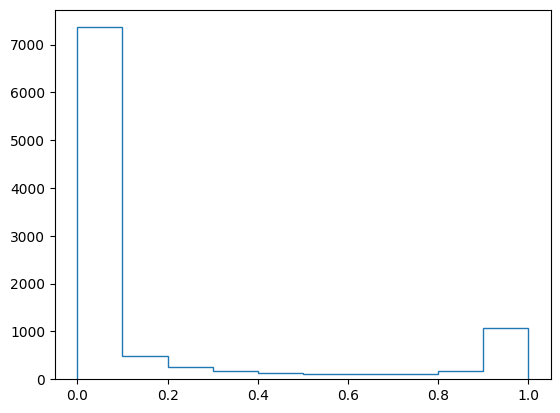

In [159]:
test_results = neural_network(params, x_test)
counts, bins = jnp.histogram(test_results)
plt.stairs(counts, bins)

In [160]:
# count percent correct
y_hat = jnp.round(neural_network(params, x_test), 0).flatten()
num_correct = jnp.sum(y_hat == y_test)
print("Classiefied {}/{} = {:.2f}% correctly".format(num_correct, len(y_hat), num_correct / len(y_hat) * 100))

Classiefied 9275/10000 = 92.75% correctly
